# Recommender Systems & Clustering usando Bayesian Non-Negative Matrix Factorization

En este cuaderno vamos a desarrollar un proyecto de sistema de recomendación basado en **factorización de matrices no negativa bayesiana (Bayesian Non-Negative Matrix Factorization, BNMF)** aplicado a un conjunto de datos real de valoraciones de usuarios sobre ítems (películas).

La idea general es:

- Partir de una **matriz usuario–ítem** con valoraciones (ratings).
- Descomponer esa matriz en factores latentes **no negativos**.
- Interpretar esos factores como **“clusters suaves”** de usuarios e ítems (cada usuario puede pertenecer a varios grupos en distinto grado).
- Utilizar el modelo como un **sistema de recomendación**, prediciendo ratings faltantes.

Trabajaremos con el dataset **MovieLens 100K**, que contiene 100 000 valoraciones de películas hechas por usuarios reales.


## Objetivos del proyecto

1. **Cargar y explorar** el dataset MovieLens 100K:
   - Ver estructura, dimensiones y tipos de datos.
   - Analizar la distribución de ratings.
   - Revisar qué tan dispersa (sparse) es la matriz usuario–ítem.

2. **Construir la matriz de valoraciones usuario–ítem**:
   - Usuarios en filas, películas en columnas.
   - Analizar el número de valoraciones por usuario y por ítem.

3. **Aplicar un modelo de NMF clásico (no bayesiano) como baseline**:
   - Descomponer la matriz en factores latentes no negativos.
   - Usar los factores para obtener predicciones de ratings.
   - Interpretar los factores como “clusters suaves”.

4. **Introducir la idea de Bayesian Non-Negative Matrix Factorization (BNMF)**:
   - Explicar las diferencias con NMF clásica.
   - Dejar preparado el código base para implementar una versión bayesiana (esqueleto para posterior desarrollo).

Este cuaderno constituye la **parte inicial** del proyecto: dataset + análisis exploratorio + preparación de datos + baseline NMF.


## Marco teórico breve

Sea una matriz de ratings \( R \in \mathbb{R}_+^{U \times I} \), donde:
- \( U \) = número de usuarios.
- \( I \) = número de ítems (películas).
- \( R_{u,i} \) es el rating que el usuario \( u \) da al ítem \( i \) (si existe).

La **Non-Negative Matrix Factorization (NMF)** busca matrices \( W \) y \( H \) tales que:

\[
R \approx W H
\]

con:

- \( W \in \mathbb{R}_+^{U \times K} \): factores latentes de usuarios.
- \( H \in \mathbb{R}_+^{K \times I} \): factores latentes de ítems.
- \( K \) = número de factores (dimensión latente).

Cada fila de \( W \) define “cuánto” pertenece el usuario a cada factor/cluster latente, y cada columna de \( H \) describe las características latentes de cada ítem.

### Versión bayesiana (BNMF, muy resumido)

En la **BNMF** no buscamos un solo \( W \) y \( H \), sino una **distribución posterior** sobre ellos. Una forma común es:

- Asumir que los ratings o conteos siguen una distribución (por ejemplo, Poisson o Gaussiana).
- Poner **priors** sobre \( W \) y \( H \) (por ejemplo, priors Gamma para garantizar no negatividad).
- Mediante métodos como MCMC o variational inference se actualizan las distribuciones de \( W \) y \( H \).

La ventaja es que obtenemos:
- Incertidumbre sobre las predicciones.
- Regularización bayesiana de forma “natural”.
- Interpretación probabilística de los factores/“clusters”.

En este cuaderno empezaremos con NMF clásica e iremos preparando el terreno para una extensión bayesiana.


In [14]:

# Si estás en Google Colab, puedes necesitar instalar algunas librerías.
# Descomenta si lo necesitas:

!pip install pandas numpy matplotlib seaborn scikit-learn

import os
import zipfile
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Configuración gráfica
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
sns.set()



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Dataset: MovieLens 100K

Usaremos el dataset **MovieLens 100K**, mantenido por el GroupLens Research.

Características principales:

- ~100 000 ratings.
- 943 usuarios.
- 1682 películas.
- Ratings en una escala de 1 a 5.
- Cada usuario ha calificado **al menos 20 películas**.

En este cuaderno descargaremos automáticamente el archivo desde la fuente oficial (si hay conexión a internet). Si no hay internet, la descarga fallará y será necesario agregar manualmente los archivos.


In [15]:
# URL oficial del MovieLens 100K
url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
data_dir = "data"
ml_dir = os.path.join(data_dir, "ml-100k")

os.makedirs(data_dir, exist_ok=True)

# Descargar el zip si no existe
zip_path = os.path.join(data_dir, "ml-100k.zip")

if not os.path.exists(ml_dir):
    if not os.path.exists(zip_path):
        print("Descargando MovieLens 100K...")
        urllib.request.urlretrieve(url, zip_path)
        print("Descarga completa.")
    else:
        print("Zip ya existe, no se vuelve a descargar.")

    # Descomprimir
    print("Descomprimiendo...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(data_dir)
    print("Descompresión completa.")
else:
    print("Directorio ml-100k ya existe, saltando descarga.")

# Archivo principal de ratings: u.data
ratings_path = os.path.join(ml_dir, "u.data")

# Cargar en un DataFrame
ratings = pd.read_csv(
    ratings_path,
    sep="\t",
    names=["user_id", "item_id", "rating", "timestamp"],
    engine="python"
)

ratings.head()


Directorio ml-100k ya existe, saltando descarga.


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Inspección inicial del dataset

Revisaremos:

- Las primeras filas del DataFrame.
- Tamaño y estructura (shape, info).
- Estadísticos básicos de los ratings.

Esto nos da una idea rápida del contenido antes de pasar a un análisis más detallado.


In [16]:
print("Dimensiones del DataFrame ratings:", ratings.shape)
print("\nInformación general:")
print(ratings.info())

print("\nDistribución básica de ratings:")
print(ratings["rating"].describe())

ratings.head()


Dimensiones del DataFrame ratings: (100000, 4)

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None

Distribución básica de ratings:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [17]:
# Convertimos user_id y item_id a tipo categórico (útil para algunos análisis)
ratings["user_id"] = ratings["user_id"].astype("category")
ratings["item_id"] = ratings["item_id"].astype("category")

n_users = ratings["user_id"].nunique()
n_items = ratings["item_id"].nunique()

print(f"Número de usuarios: {n_users}")
print(f"Número de ítems (películas): {n_items}")


Número de usuarios: 943
Número de ítems (películas): 1682


## Análisis exploratorio 1: Distribución de ratings

Como primer paso, analizamos cómo se distribuyen los ratings (1–5). 

Esto nos dice:
- Si los usuarios tienden a ser **más positivos** (ratings altos) o más críticos.
- Si hay clases de rating poco utilizadas.

Visualizaremos:
- Un **histograma** de los ratings.
- Un **conteo** por categoría (1, 2, 3, 4, 5).


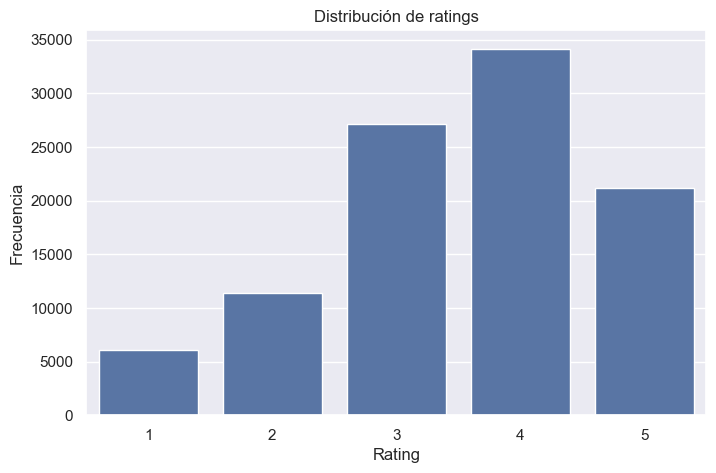

rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64

In [18]:
fig, ax = plt.subplots()

sns.countplot(x="rating", data=ratings, ax=ax)
ax.set_title("Distribución de ratings")
ax.set_xlabel("Rating")
ax.set_ylabel("Frecuencia")

plt.show()

ratings["rating"].value_counts().sort_index()


## Análisis exploratorio 2: actividad de usuarios e ítems

También es importante ver:

- **Cuántos ratings hace cada usuario**  
- **Cuántos ratings recibe cada ítem/película**

Esto nos ayuda a entender:
- Si hay usuarios muy activos y otros casi inactivos.
- Si hay películas muy populares y otras casi sin valoraciones.

Calcularemos:
- Conteo de ratings por usuario.
- Conteo de ratings por ítem.
- Algunas estadísticas (mínimo, máximo, cuartiles).


Estadísticos de ratings por usuario:
count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64

Estadísticos de ratings por ítem:
count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: rating, dtype: float64


C:\Users\MSI\AppData\Local\Temp\ipykernel_12728\1870818731.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_counts = ratings.groupby("user_id")["rating"].count()
C:\Users\MSI\AppData\Local\Temp\ipykernel_12728\1870818731.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  item_counts = ratings.groupby("item_id")["rating"].count()


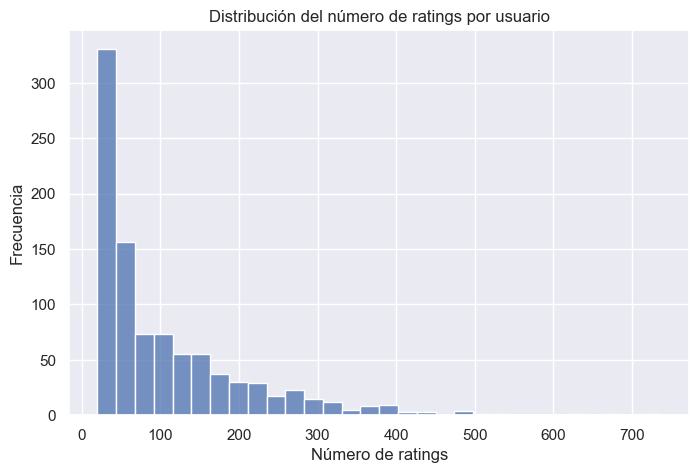

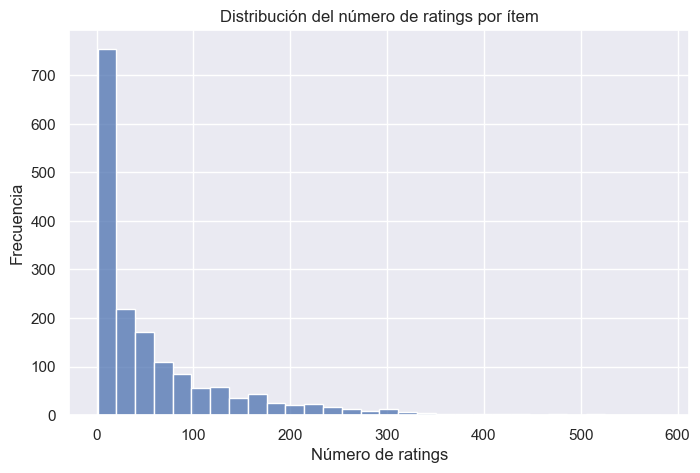

In [19]:
# Ratings por usuario
user_counts = ratings.groupby("user_id")["rating"].count()
item_counts = ratings.groupby("item_id")["rating"].count()

print("Estadísticos de ratings por usuario:")
print(user_counts.describe())

print("\nEstadísticos de ratings por ítem:")
print(item_counts.describe())

# Distribución de ratings por usuario (histograma)
fig, ax = plt.subplots()
sns.histplot(user_counts, bins=30, kde=False, ax=ax)
ax.set_title("Distribución del número de ratings por usuario")
ax.set_xlabel("Número de ratings")
ax.set_ylabel("Frecuencia")
plt.show()

# Distribución de ratings por ítem (histograma)
fig, ax = plt.subplots()
sns.histplot(item_counts, bins=30, kde=False, ax=ax)
ax.set_title("Distribución del número de ratings por ítem")
ax.set_xlabel("Número de ratings")
ax.set_ylabel("Frecuencia")
plt.show()


## Construcción de la matriz usuario–ítem

Para aplicar NMF (y después BNMF), necesitamos una **matriz \( R \)** donde:

- Cada fila representa un usuario.
- Cada columna representa un ítem.
- La entrada \( R_{u,i} \) es el rating del usuario \( u \) al ítem \( i \), si existe.

Como hay muchos ratings faltantes, la matriz será **dispersa (sparse)**.
Usaremos un `pivot_table` de `pandas` y luego convertiremos a `numpy`.


In [20]:
# Pivot para crear matriz usuario–ítem
rating_matrix = ratings.pivot_table(
    values="rating",
    index="user_id",
    columns="item_id"
)

print("Shape de la matriz usuario–ítem:", rating_matrix.shape)

# Porcentaje de celdas no nulas (densidad)
non_null = rating_matrix.count().sum()
total_cells = rating_matrix.shape[0] * rating_matrix.shape[1]
density = non_null / total_cells

print(f"Número de celdas con rating: {non_null}")
print(f"Número total de celdas: {total_cells}")
print(f"Densidad de la matriz: {density * 100:.4f}%")

rating_matrix.head()


Shape de la matriz usuario–ítem: (943, 1682)
Número de celdas con rating: 100000
Número total de celdas: 1586126
Densidad de la matriz: 6.3047%


C:\Users\MSI\AppData\Local\Temp\ipykernel_12728\1067670712.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rating_matrix = ratings.pivot_table(


item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


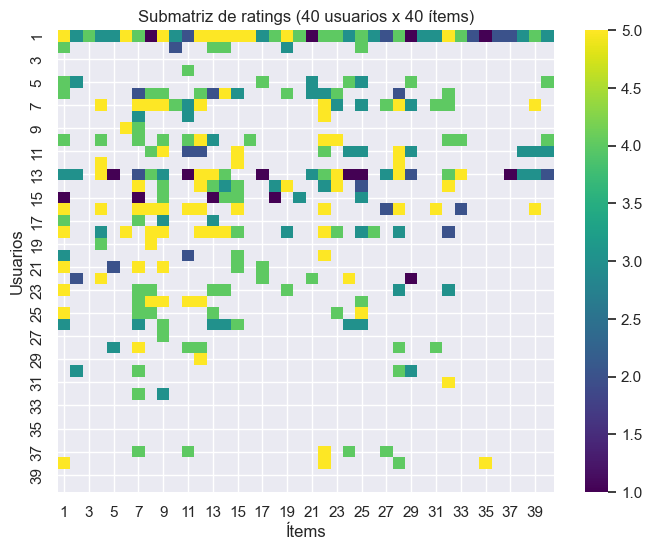

In [21]:
# Tomamos un subconjunto (por ejemplo, primeros 40 usuarios y 40 ítems) para visualizar.
submatrix = rating_matrix.iloc[:40, :40]

plt.figure(figsize=(8, 6))
sns.heatmap(submatrix, cmap="viridis", cbar=True)
plt.title("Submatriz de ratings (40 usuarios x 40 ítems)")
plt.xlabel("Ítems")
plt.ylabel("Usuarios")
plt.show()


## Preparación para NMF (baseline)

La implementación estándar de `sklearn.decomposition.NMF` **no acepta valores NaN**, así que debemos:

1. Reemplazar los valores faltantes con algún valor (por ejemplo, 0).
2. Guardar una máscara para saber **qué posiciones tienen realmente rating** (para calcular el error de predicción solo allí).

Después:
- Separaremos un conjunto de entrenamiento y prueba de manera basada en filas (usuarios) o en entradas individuales.
Aquí comenzaremos con una separación simple basada en **usuarios**.


In [22]:
# Convertimos a numpy y reemplazamos NaN por 0
R = rating_matrix.fillna(0).to_numpy(dtype=float)

# Máscara de posiciones observadas (True donde hay rating > 0)
mask_observed = (R > 0).astype(int)

R.shape, mask_observed.shape


((943, 1682), (943, 1682))

In [23]:
# Creamos índices de usuarios
user_indices = np.arange(R.shape[0])

# Dividimos usuarios en train y test
train_users, test_users = train_test_split(
    user_indices, test_size=0.2, random_state=42
)

R_train = R[train_users, :]
R_test = R[test_users, :]
mask_train = mask_observed[train_users, :]
mask_test = mask_observed[test_users, :]

print("Shape R_train:", R_train.shape)
print("Shape R_test:", R_test.shape)


Shape R_train: (754, 1682)
Shape R_test: (189, 1682)


## Baseline: NMF clásica

Como primer modelo aproximaremos la matriz de ratings con **NMF clásica**, sin parte bayesiana todavía:

\[
R \approx W H
\]

donde:

- \( W \in \mathbb{R}_+^{U \times K} \)
- \( H \in \mathbb{R}_+^{K \times I} \)

Pasos:

1. Elegir un número de factores latentes \( K \) (por ejemplo, 10, 20, etc.).
2. Ajustar la NMF sobre la parte `R_train`.
3. Reconstruir \( \hat{R} = W H \).
4. Evaluar el error (RMSE) solo en posiciones con rating observado.

Esto servirá como **baseline** antes de implementar una versión bayesiana.


In [24]:
K = 20  # número de factores latentes (puedes cambiarlo y experimentar)

nmf_model = NMF(
    n_components=K,
    init="random",
    random_state=42,
    max_iter=200
)

# Ajustamos NMF usando solo R_train
W_train = nmf_model.fit_transform(R_train)   # (n_train_users x K)
H = nmf_model.components_                    # (K x n_items)

# Reconstrucción de R para usuarios de entrenamiento
R_train_hat = np.dot(W_train, H)

# Calculamos RMSE en el set de entrenamiento (solo en celdas observadas)
train_mask_flat = mask_train.flatten()
train_true = R_train.flatten()[train_mask_flat == 1]
train_pred = R_train_hat.flatten()[train_mask_flat == 1]

rmse_train = np.sqrt(mean_squared_error(train_true, train_pred))
print(f"RMSE en entrenamiento (NMF clásica, K={K}): {rmse_train:.4f}")


RMSE en entrenamiento (NMF clásica, K=20): 2.2216


c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [25]:
# Ajustamos de nuevo pero sobre toda la matriz R (para tener W y H globales)
nmf_full = NMF(
    n_components=K,
    init="random",
    random_state=42,
    max_iter=200
)

W_full = nmf_full.fit_transform(R)
H_full = nmf_full.components_

R_hat_full = np.dot(W_full, H_full)

# Extraemos solo usuarios de test
R_test_true = R[test_users, :]
R_test_hat = R_hat_full[test_users, :]
mask_test = mask_observed[test_users, :]

test_mask_flat = mask_test.flatten()
test_true = R_test_true.flatten()[test_mask_flat == 1]
test_pred = R_test_hat.flatten()[test_mask_flat == 1]

rmse_test = np.sqrt(mean_squared_error(test_true, test_pred))
print(f"RMSE en test (NMF clásica, K={K}): {rmse_test:.4f}")


RMSE en test (NMF clásica, K=20): 2.2197


c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## Interpretación de factores como "clusters suaves"

Los factores latentes aprendidos por NMF se pueden interpretar como:

- Cada fila de \( W \) (usuario) indica **cuánto pertenece el usuario** a cada factor o “cluster latente”.
- Cada columna de \( H \) (ítem) indica **qué tan relacionado está el ítem** con cada factor.

En la práctica:

- Usuarios con perfiles similares tendrán filas de \( W \) parecidas.
- Ítems similares (por ejemplo, películas del mismo género) tenderán a compartir patrones en \( H \).

Aunque no hemos realizado aún un **modelo bayesiano completo**, esta estructura ya nos permite hacer:
- **Clustering suave** (soft clustering) de usuarios e ítems.
- **Recomendaciones**: para cada usuario, tomar los ítems con mayor valor en la fila correspondiente de \( \hat{R} \) en posiciones donde faltan ratings.

En la siguiente fase del proyecto se puede:
- Implementar una **Bayesian Non-Negative Matrix Factorization (BNMF)** usando priors Gamma y una función de verosimilitud (por ejemplo Gaussiana o Poisson).
- Comparar el rendimiento y las propiedades (incertidumbre, regularización) frente a la NMF clásica.


## Esqueleto para la implementación de BNMF

A continuación dejamos un **esqueleto** de código para una implementación simple de BNMF mediante un enfoque tipo Gibbs sampling.
No está completo (requiere bastante más desarrollo matemático y programático), pero sirve como guía para la siguiente etapa del proyecto:

- Definir priors Gamma para \( W \) y \( H \).
- Elegir una verosimilitud (Gaussiana o Poisson).
- Implementar las actualizaciones de \( W \) y \( H \) en cada iteración del sampler.
- Guardar muestras para aproximar la distribución posterior.

Este bloque es opcional y se usa como base para trabajo futuro.


In [ ]:
# ESQUELETO MUY SIMPLIFICADO (NO FUNCIONAL COMPLETO) PARA BNMF
# Este bloque es solo una guía de cómo se podría estructurar el código.

class BayesianNMF:
    def __init__(self, R, K, alpha_w=0.1, beta_w=0.1, alpha_h=0.1, beta_h=0.1, n_iter=1000, random_state=42):
        """
        R: matriz de ratings (U x I)
        K: número de factores latentes
        alpha_w, beta_w: hiperparámetros de la prior Gamma para W
        alpha_h, beta_h: hiperparámetros de la prior Gamma para H
        n_iter: número de iteraciones del sampler
        """
        np.random.seed(random_state)
        self.R = R
        self.K = K
        self.U, self.I = R.shape
        self.alpha_w = alpha_w
        self.beta_w = beta_w
        self.alpha_h = alpha_h
        self.beta_h = beta_h
        self.n_iter = n_iter

        # Inicialización aleatoria no negativa
        self.W = np.random.gamma(1.0, 1.0, size=(self.U, self.K))
        self.H = np.random.gamma(1.0, 1.0, size=(self.K, self.I))

    def fit(self):
        """
        Aquí irían las actualizaciones de W y H siguiendo las
        ecuaciones de Gibbs sampling o variational inference,
        dependiendo del modelo (Gaussiano, Poisson, etc.).
        """
        for it in range(self.n_iter):
            # TODO: actualizar self.W y self.H según la distribución posterior
            #       usando las fórmulas de actualización correspondientes.
            pass

        return self

    def reconstruct(self):
        return np.dot(self.W, self.H)
    